# BayesOPT Example for showing Gittins >> EI
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aimed to show the limitation of EIpu and EI. This experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and compares Gittins with EIpu/EI.

In [2]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

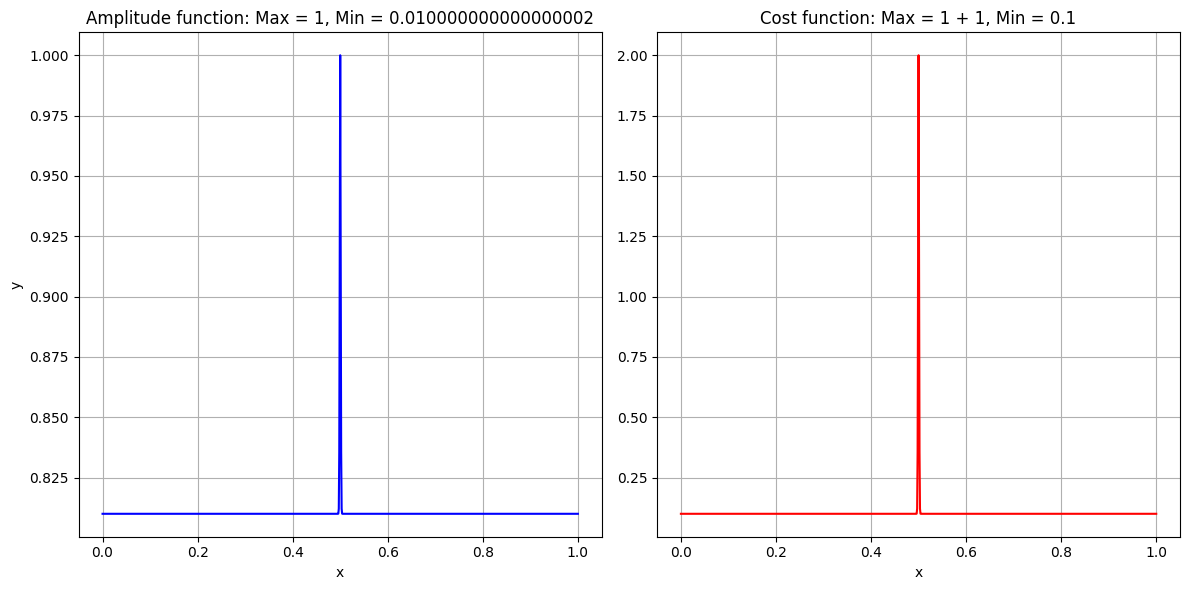

In [2]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta, and a moderate value for K
cost_function_epsilon = 0.1
cost_function_delta = 9
amplitude_function_width = 0.002
cost_function_width = 0.002

# Define the functions for the amplitude and the cost
def squared_euclidean_distance(x, center):
    # Calculate the squared Euclidean distance
    return torch.sum((x - center) ** 2, dim=-1)

def amplitude_function(x):
    center = torch.full_like(x, 0.5)  # Center at [0.5, 0.5, ...]
    dist_squared = squared_euclidean_distance(x, center)
    amplitude = torch.exp(-dist_squared / (2 * amplitude_function_width**2)) * (1 - (1-cost_function_epsilon)**2) + (1-cost_function_epsilon)**2
    return amplitude

def cost_function(x):
    center = torch.full_like(x, 0.5)  # Center at [0.5, 0.5, ...]
    width = cost_function_width
    peak_height = 1 + cost_function_delta - cost_function_epsilon
    dist_squared = squared_euclidean_distance(x, center)
    cost = torch.exp(-dist_squared / (2 * width**2)) * peak_height + cost_function_epsilon
    return cost

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {cost_function_epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {cost_function_delta}, Min = {cost_function_epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

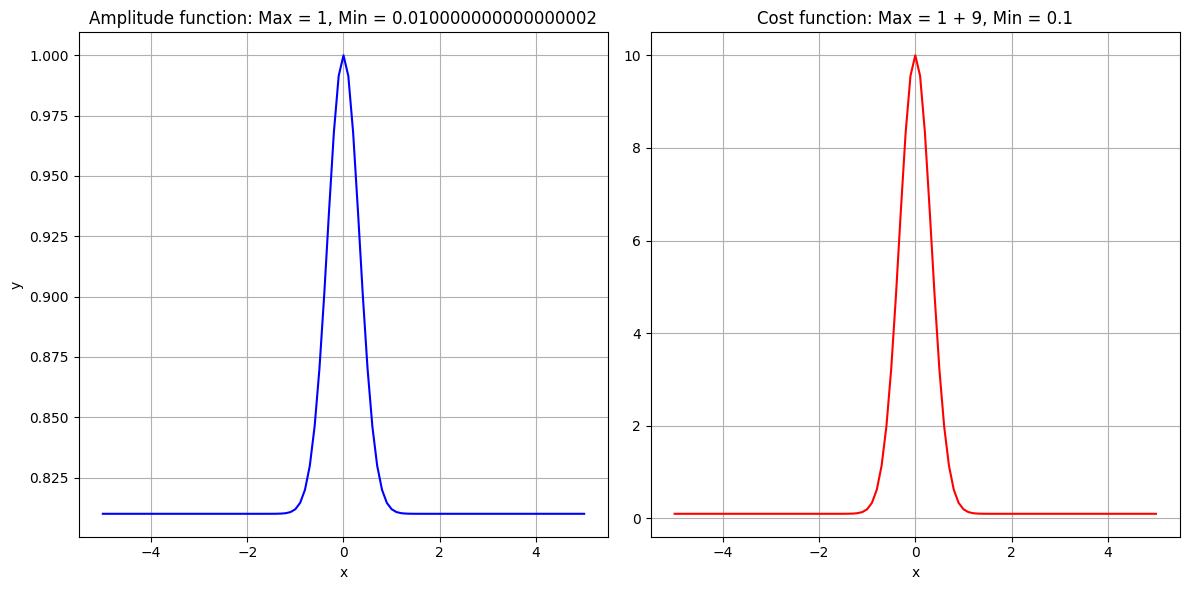

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Define typical small values for epsilon and delta, and a moderate value for K
cost_function_epsilon = 0.1
cost_function_delta = 9
amplitude_function_width = 0.002
cost_function_width = 0.002
amplitude_function_sigma = amplitude_function_width / (2*np.sqrt(-2 * np.log(cost_function_epsilon**2)))
cost_function_sigma = cost_function_width / (2*np.sqrt(-2 * np.log(cost_function_epsilon**2)))

# Define the functions for the amplitude and the cost
def squared_euclidean_distance(x, center):
    # Calculate the squared Euclidean distance
    return torch.sum((x - center) ** 2, dim=-1)

def amplitude_function(x):
    x_scaled = (x+500)/1000
    center = torch.full_like(x_scaled, 0.5)  # Center at [0.5, 0.5, ...]
    dist_squared = squared_euclidean_distance(x_scaled, center)
    amplitude = torch.exp(-dist_squared / (2 * amplitude_function_sigma**2)) * (1 - (1-cost_function_epsilon)**2) + (1-cost_function_epsilon)**2
    return amplitude.cpu().numpy()

def cost_function(x):
    x_scaled = (x+500)/1000
    center = torch.full_like(x, 0.5)  # Center at [0.5, 0.5, ...]
    peak_height = 1 + cost_function_delta - cost_function_epsilon
    dist_squared = squared_euclidean_distance(x_scaled, center)
    cost = torch.exp(-dist_squared / (2 * cost_function_sigma**2)) * peak_height + cost_function_epsilon
    return cost.cpu().numpy()

# Generate x values from 0 to 1
x_values = torch.linspace(-5, 5, 101)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {cost_function_epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {cost_function_delta}, Min = {cost_function_epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
import csv
# Specify the header
header = ['x', 'amplitude', 'cost']

# Open a CSV file for writing
with open('ei_example.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(header)

    # Write the data
    for data in zip(list(x_values.numpy()), y_values_amplitude, y_values_cost):
        writer.writerow(data)

### TODO
Adjust the hyperparamters to get a larger discrepancy between EIpu and Gittins

### Question
Is it necessary to pass epsilon = 0.1, delta = 0.05, K = 100 as parameters to amplitude_function and cost_function?

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [3]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 2.5
lengthscale = 0.01
outputscale = 1.0
num_rff_features = 1280
seed = 0
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

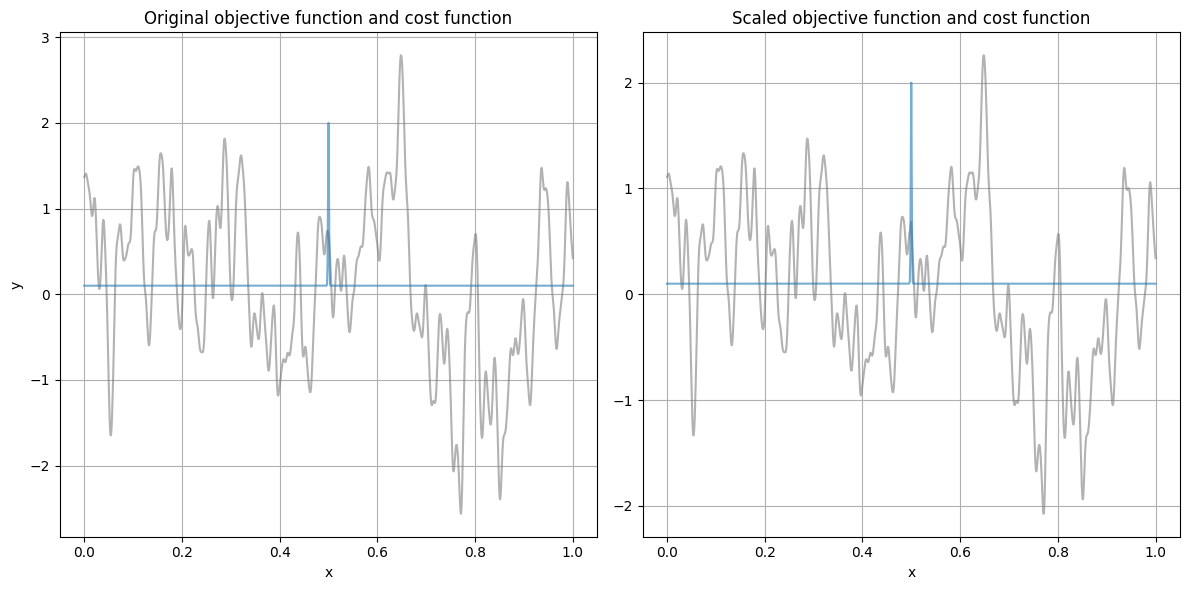

In [4]:
test_x = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), matern_sample(test_x.view(-1,1)).numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [6]:
from gpytorch.kernels import MaternKernel
from pandora_bayesopt.kernel import VariableAmplitudeKernel

### Note
This class VariableAmplitudeKernel can be found in pandora_bayesopt.kernel

## Fit a GP model with observation data and a specified kernel

In [7]:
from pandora_bayesopt.utils import fit_gp_model

### Note
This function can be found in pandora_bayesopt.utils

In [8]:
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

### Question
Instead of setting the kernel inside fit_gp_model with given smoothness and lengthscale parameters, I set the kernel before running the BayesOPT loop so that I can also use fit_gp_model with a standard Matern kernel (base_kernel) for other tasks. However, it seems that if I only set it once, then it would be a different initial kernel when I run another policy. Not sure why this happens. To avoid such issues, I reset it before running every policy.

In [9]:
maximize = True
budget = 3+cost_function_delta

In [10]:
from pandora_bayesopt.utils import find_global_optimum
global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

global_optimum tensor([0.6492]) 2.2497077087979602



## Test EI policy

initial x: tensor([[0.]])
initial y: tensor([1.1079])
best oberved value: 1.1079166555859041


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1079]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


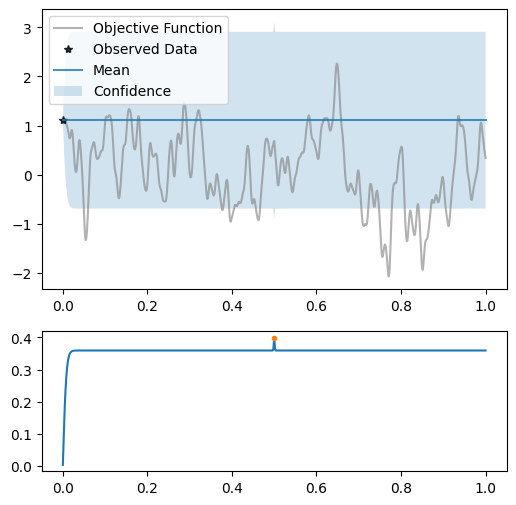

Iteration 0, measuring at x=0.4999999998452105, y=0.6845484766967719
best oberved value: 1.1079166555859041
new cost: 1.9999999999999771
cumulative cost: 1.9999999999999771


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8962]), std = tensor([0.2994])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


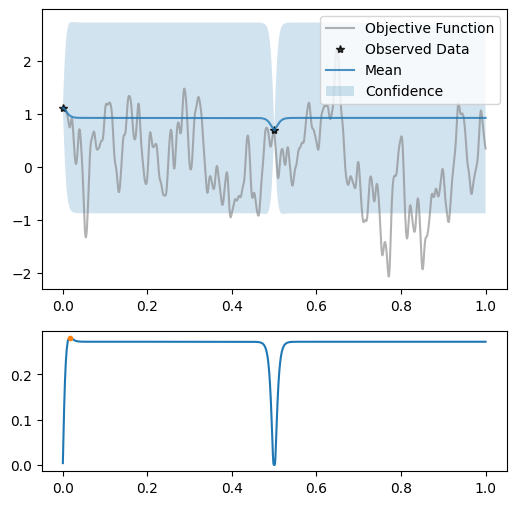

Iteration 1, measuring at x=0.016641286441945118, y=0.7415129463927232
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.099999999999977


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8447]), std = tensor([0.2298])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


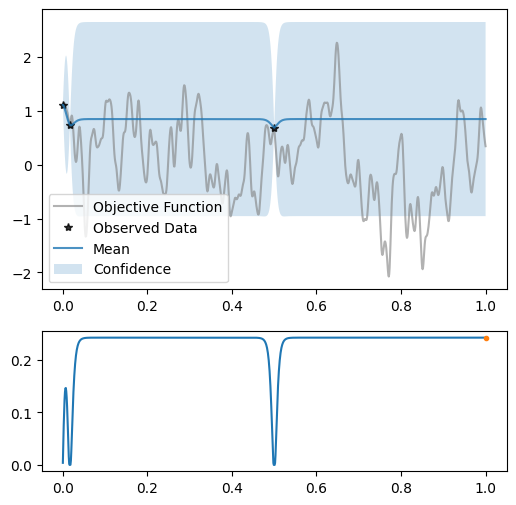

Iteration 2, measuring at x=1.0, y=0.34142769027985315
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.199999999999977
Iteration 3, measuring at x=0.7010105306579111, y=-0.04048262031675653
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.299999999999977
Iteration 4, measuring at x=0.006481294917569059, y=1.0800860832600454
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.3999999999999773
Iteration 5, measuring at x=0.5207650221317395, y=0.2878329319721581
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.4999999999999774


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7189]), std = tensor([0.3139])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5670]), std = tensor([0.4350])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6525]), std = tensor([0.4419])). Please consider scaling the 

Iteration 6, measuring at x=0.04067550135211508, y=0.653574185069901
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.5999999999999774
Iteration 7, measuring at x=0.4807570528945637, y=0.7263825660792397
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.6999999999999775
Iteration 8, measuring at x=0.4615840911396831, y=-0.9170586429076071
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.7999999999999776


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6071]), std = tensor([0.3951])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6203]), std = tensor([0.3717])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4666]), std = tensor([0.5993])). Please consider scaling the 

Iteration 9, measuring at x=0.05740233884362882, y=-1.098335709966032
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.8999999999999777
Iteration 10, measuring at x=0.030175956556619914, y=0.06527395879225606
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 2.999999999999978
Iteration 11, measuring at x=0.9787355949035094, y=0.0153277948853334
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 3.099999999999978


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3243]), std = tensor([0.7388])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3027]), std = tensor([0.7084])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2806]), std = tensor([0.6829])). Please consider scaling the 

Iteration 12, measuring at x=0.5459567279908524, y=-0.2428229076716107
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 3.199999999999978
Iteration 13, measuring at x=0.48957238770454115, y=0.4259686053953758
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 3.299999999999978
Iteration 14, measuring at x=0.27250228821690864, y=0.8305631636545451
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 3.399999999999978
Iteration 15, measuring at x=0.28344926792915276, y=1.1462001090776361
best oberved value: 1.1462001090776361
new cost: 0.1
cumulative cost: 3.4999999999999782


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2432]), std = tensor([0.6709])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2554]), std = tensor([0.6482])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2914]), std = tensor([0.6425])). Please consider scaling the 

Iteration 16, measuring at x=0.29163792106172476, y=1.226689284298755
best oberved value: 1.226689284298755
new cost: 0.1
cumulative cost: 3.5999999999999783
Iteration 17, measuring at x=0.3003997713457504, y=0.0009952601127701268
best oberved value: 1.226689284298755
new cost: 0.1
cumulative cost: 3.6999999999999784


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3908]), std = tensor([0.6695])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3703]), std = tensor([0.6567])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 18, measuring at x=0.28833248529820593, y=1.4556343197861958
best oberved value: 1.4556343197861958
new cost: 0.1
cumulative cost: 3.7999999999999785
Iteration 19, measuring at x=0.25849873602167095, y=0.5252938123741482
best oberved value: 1.4556343197861958
new cost: 0.1
cumulative cost: 3.8999999999999786
Iteration 20, measuring at x=0.23719103847641582, y=-0.5246246419676533
best oberved value: 1.4556343197861958
new cost: 0.1
cumulative cost: 3.9999999999999787
Iteration 21, measuring at x=0.8404797549211277, y=-0.6090342012007763
best oberved value: 1.4556343197861958
new cost: 0.1
cumulative cost: 4.099999999999978


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4246]), std = tensor([0.6838])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4294]), std = tensor([0.6668])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3860]), std = tensor([0.6818])). Please consider scaling the 

In [11]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.kernels import MaternKernel

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
print("initial x:", x)
print("initial y:", y)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.stack([torch.zeros(dim), torch.ones(dim)]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
        
        # Plot the posterior and the EI
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EI
        acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
        
        
        plt.show()
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Question
- Do I need to care about these warnings?

## Test EI per unit cost policy

best oberved value: 1.1079166555859041


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1079]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


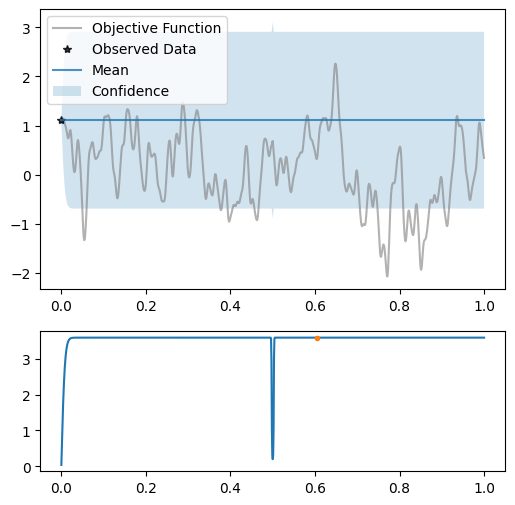

Iteration 0, measuring at x=0.6053624842315912, y=0.3523506681039094
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7301]), std = tensor([0.5343])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


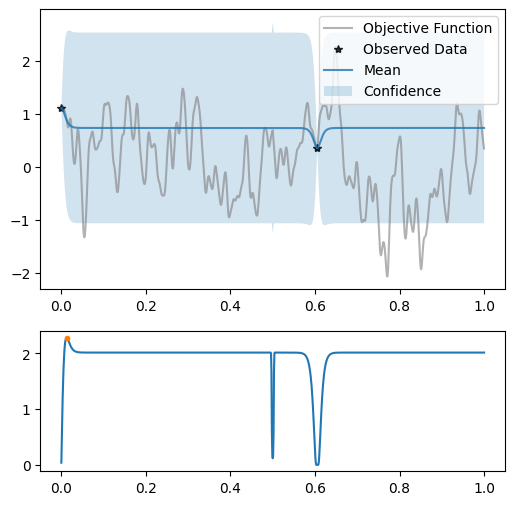

Iteration 1, measuring at x=0.012461029609040952, y=0.8901676769228565
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7835]), std = tensor([0.3889])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


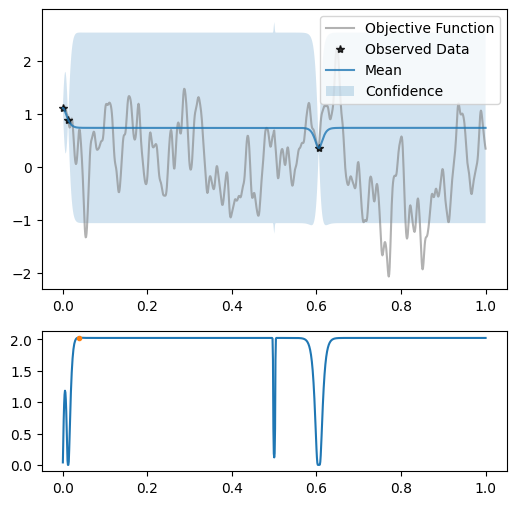

Iteration 2, measuring at x=0.03825695749054109, y=0.6802197531412744
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.30000000000000004
Iteration 3, measuring at x=0.8443781491369011, y=-1.029675963432175
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.4


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7577]), std = tensor([0.3217])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4002]), std = tensor([0.8465])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 4, measuring at x=0.005148817224131519, y=1.11734075182356
best oberved value: 1.11734075182356
new cost: 0.1
cumulative cost: 0.5
Iteration 5, measuring at x=0.025674396504227814, y=0.4985236645935016
best oberved value: 1.11734075182356
new cost: 0.1
cumulative cost: 0.6
Iteration 6, measuring at x=0.05338561477343825, y=-1.3104228971560004
best oberved value: 1.11734075182356
new cost: 0.1
cumulative cost: 0.7


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5197]), std = tensor([0.8118])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5167]), std = tensor([0.7411])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2883]), std = tensor([0.9424])). Please consider scaling the 

Iteration 7, measuring at x=0.6224256189802467, y=1.1421095863357913
best oberved value: 1.1421095863357913
new cost: 0.1
cumulative cost: 0.7999999999999999
Iteration 8, measuring at x=0.6296606821120387, y=0.9933290289364848
best oberved value: 1.1421095863357913
new cost: 0.1
cumulative cost: 0.8999999999999999
Iteration 9, measuring at x=0.6427374291628507, y=1.6357394105652803
best oberved value: 1.6357394105652803
new cost: 0.1
cumulative cost: 0.9999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3832]), std = tensor([0.9263])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4442]), std = tensor([0.8944])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5525]), std = tensor([0.9214])). Please consider scaling the 

Iteration 10, measuring at x=0.648634320238522, y=2.260628236738298
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.0999999999999999
Iteration 11, measuring at x=0.6530322939210055, y=1.884066312722101
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6949]), std = tensor([1.0074])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7863]), std = tensor([1.0194])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 12, measuring at x=0.6476388633625282, y=2.251701954126202
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.3
Iteration 13, measuring at x=0.6694488485323494, y=-0.14613926387292442
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.4000000000000001
Iteration 14, measuring at x=0.33963301964104176, y=-0.3724831868376193
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.5000000000000002
Iteration 15, measuring at x=0.19729476223833853, y=-0.32803670326472745
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.6000000000000003


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8910]), std = tensor([1.0548])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8219]), std = tensor([1.0511])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7472]), std = tensor([1.0585])). Please consider scaling the 

Iteration 16, measuring at x=0.999799996903152, y=0.35021433491716575
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.7000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6654]), std = tensor([1.0289])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 17, measuring at x=0.9743757916609557, y=-0.15509091983447187
best oberved value: 2.260628236738298
new cost: 0.1
cumulative cost: 1.8000000000000005
Iteration 18, measuring at x=0.648400990778918, y=2.26218288860882
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 1.9000000000000006
Iteration 19, measuring at x=0.5683131343587197, y=0.4464330529089706
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.0000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6222]), std = tensor([1.0175])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7042]), std = tensor([1.0561])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6920]), std = tensor([1.0309])). Please consider scaling the 

Iteration 20, measuring at x=0.5464052402296021, y=-0.21142715170545928
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.1000000000000005
Iteration 21, measuring at x=0.4433607364864416, y=-0.02486109689322408
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.2000000000000006


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6509]), std = tensor([1.0243])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6215]), std = tensor([1.0106])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 22, measuring at x=0.7549710233868022, y=-1.6547565622714675
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.3000000000000007


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5267]), std = tensor([1.0922])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 23, measuring at x=0.26904755220701115, y=0.5802980138301008
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.400000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5288]), std = tensor([1.0692])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 24, measuring at x=0.251698239197544, y=0.40971446542210604
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.500000000000001
Iteration 25, measuring at x=0.28710563852655463, y=1.4727886313929477
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.600000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5242]), std = tensor([1.0479])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5594]), std = tensor([1.0436])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 26, measuring at x=0.2968196094428738, y=0.4283787217314088
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.700000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5547]), std = tensor([1.0244])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 27, measuring at x=0.2800235219909138, y=0.6760491725426774
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.800000000000001
Iteration 28, measuring at x=0.5853911475666649, y=1.030617919589182
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 2.9000000000000012


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5589]), std = tensor([1.0062])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5746]), std = tensor([0.9925])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 29, measuring at x=0.12854215051402937, y=-0.21893859569048252
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 3.0000000000000013


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5490]), std = tensor([0.9861])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 30, measuring at x=0.9128355924895215, y=-1.0483467507097126
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 3.1000000000000014
Iteration 31, measuring at x=0.2309790523511923, y=-0.2792322476933315
best oberved value: 2.26218288860882
new cost: 0.1
cumulative cost: 3.2000000000000015


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4991]), std = tensor([1.0104])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4755]), std = tensor([1.0036])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 32, measuring at x=0.6483889936066014, y=2.2622042901964
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.3000000000000016
Iteration 33, measuring at x=0.49159508122079343, y=0.37564762380601296
best oberved value: 2.2622042901964
new cost: 0.10000000000000088
cumulative cost: 3.4000000000000026


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5280]), std = tensor([1.0347])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5237]), std = tensor([1.0197])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 34, measuring at x=0.5117423793394046, y=-0.09932805627389225
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.5000000000000027
Iteration 35, measuring at x=0.4720618919374892, y=-0.06909238392478387
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.6000000000000028


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5064]), std = tensor([1.0104])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4908]), std = tensor([1.0007])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 36, measuring at x=0.3959379404024755, y=-0.9411149276817815
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.700000000000003
Iteration 37, measuring at x=0.7083215844651535, y=-0.9163277550383321
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.800000000000003
Iteration 38, measuring at x=0.8009870493166181, y=0.5708421374709642
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 3.900000000000003


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4531]), std = tensor([1.0141])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4180]), std = tensor([1.0244])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4219]), std = tensor([1.0115])). Please consider scaling the 

Iteration 39, measuring at x=0.8159447649844825, y=-1.280074364028274
best oberved value: 2.2622042901964
new cost: 0.1
cumulative cost: 4.000000000000003


In [12]:
from pandora_bayesopt.acquisition.ei_puc import ExpectedImprovementWithCost

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpu_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpu_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    new_point, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
    
        # Plot the posterior and the EIpu
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EIpu
        acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpu.numpy(),'.')
        
        plt.show()

    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpu_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpu_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test EI with cost-cooling

best oberved value: 1.1079166555859041


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1079]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


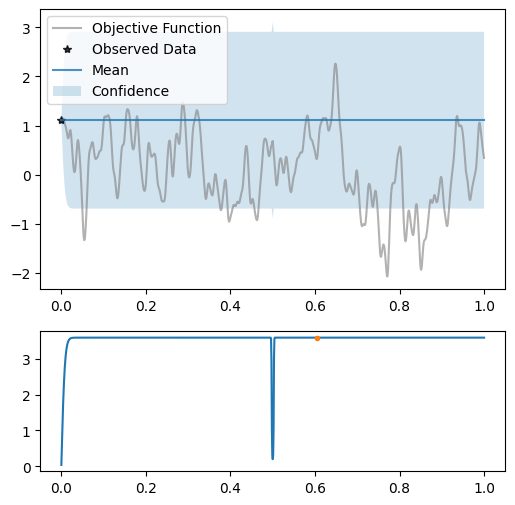

Iteration 0, measuring at x=0.6053624842315912, y=0.3523506681039094
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.1
alpha: 1.0



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7301]), std = tensor([0.5343])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


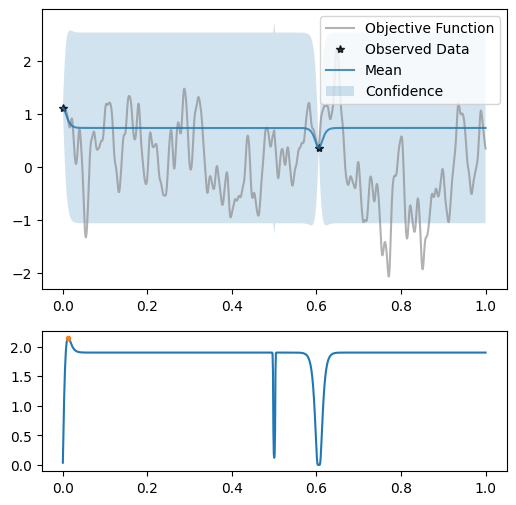

Iteration 1, measuring at x=0.012460763978647673, y=0.8901816190283186
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.2
alpha: 0.975



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7835]), std = tensor([0.3889])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


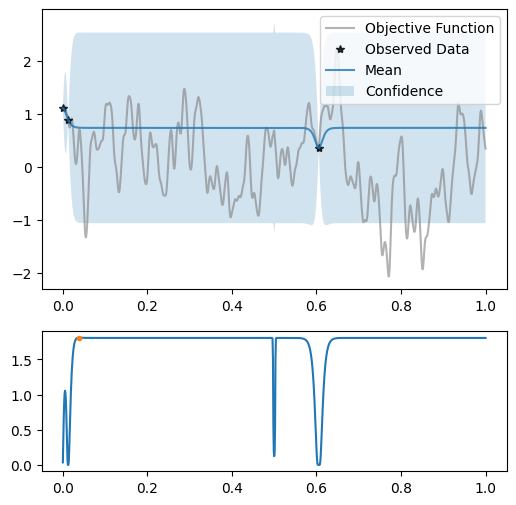

Iteration 2, measuring at x=0.03824604735640918, y=0.6796548932646161
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.30000000000000004
alpha: 0.95

Iteration 3, measuring at x=0.844378149136901, y=-1.029675963432175
best oberved value: 1.1079166555859041
new cost: 0.1
cumulative cost: 0.4
alpha: 0.925



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7575]), std = tensor([0.3218])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4001]), std = tensor([0.8464])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 4, measuring at x=0.0051485538204732945, y=1.117347043439847
best oberved value: 1.117347043439847
new cost: 0.1
cumulative cost: 0.5
alpha: 0.9

Iteration 5, measuring at x=0.02566596577379834, y=0.4996881870366625
best oberved value: 1.117347043439847
new cost: 0.1
cumulative cost: 0.6
alpha: 0.875



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5196]), std = tensor([0.8117])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5168]), std = tensor([0.7411])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 6, measuring at x=0.053392984362344194, y=-1.3108539566936777
best oberved value: 1.117347043439847
new cost: 0.1
cumulative cost: 0.7
alpha: 0.85



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2883]), std = tensor([0.9425])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 7, measuring at x=0.6224244444679882, y=1.1421102226301671
best oberved value: 1.1421102226301671
new cost: 0.1
cumulative cost: 0.7999999999999999
alpha: 0.825

Iteration 8, measuring at x=0.6296591494145363, y=0.9934185673144984
best oberved value: 1.1421102226301671
new cost: 0.1
cumulative cost: 0.8999999999999999
alpha: 0.8



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3832]), std = tensor([0.9264])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4442]), std = tensor([0.8945])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 9, measuring at x=0.6427334266415103, y=1.6350304062513268
best oberved value: 1.6350304062513268
new cost: 0.1
cumulative cost: 0.9999999999999999
alpha: 0.775

Iteration 10, measuring at x=0.6486326863116434, y=2.2606465753148197
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.0999999999999999
alpha: 0.75



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5525]), std = tensor([0.9214])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6948]), std = tensor([1.0075])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 11, measuring at x=0.6530296338879824, y=1.8844663018951404
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.2
alpha: 0.7250000000000001

Iteration 12, measuring at x=0.6476374524282562, y=2.251659598499475
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.3
alpha: 0.7



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7863]), std = tensor([1.0194])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8910]), std = tensor([1.0548])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 13, measuring at x=0.6694376599448895, y=-0.14533460577348983
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.4000000000000001
alpha: 0.675

Iteration 14, measuring at x=0.2484401976719081, y=-0.05544882232851448
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.5000000000000002
alpha: 0.6499999999999999

Iteration 15, measuring at x=0.42988340649767, y=-0.18595641475465238
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.6000000000000003
alpha: 0.625

Iteration 16, measuring at x=0.9998000014946823, y=0.3502141269571507
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.7000000000000004
alpha: 0.5999999999999999



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8219]), std = tensor([1.0511])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7671]), std = tensor([1.0389])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7110]), std = tensor([1.0321])). Please consider scaling the 

Iteration 17, measuring at x=0.9722550696653368, y=-0.24494966940861143
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.8000000000000005
alpha: 0.575

Iteration 18, measuring at x=0.1494915789410252, y=0.7561792390500367
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 1.9000000000000006
alpha: 0.5499999999999998



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6417]), std = tensor([0.9999])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6474]), std = tensor([0.9736])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 19, measuring at x=0.16644595274499155, y=0.6727769029683973
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.0000000000000004
alpha: 0.5249999999999999

Iteration 20, measuring at x=0.13150540385078338, y=-0.4613291121186097
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.1000000000000005
alpha: 0.4999999999999999



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6486]), std = tensor([0.9489])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5982]), std = tensor([0.9558])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 21, measuring at x=0.18576706992004285, y=0.39442869732408287
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.2000000000000006
alpha: 0.47499999999999987



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5893]), std = tensor([0.9348])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 22, measuring at x=0.2104294752641444, y=0.4627365914423385
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.3000000000000007
alpha: 0.44999999999999984

Iteration 23, measuring at x=0.5266530374099596, y=0.04957122342511581
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.400000000000001
alpha: 0.4249999999999998



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5841]), std = tensor([0.9146])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5627]), std = tensor([0.9017])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 24, measuring at x=0.3388023352735233, y=-0.28473242874187243
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.500000000000001
alpha: 0.3999999999999998

Iteration 25, measuring at x=0.755465300116059, y=-1.6712161548491775
best oberved value: 2.2606465753148197
new cost: 0.1
cumulative cost: 2.600000000000001
alpha: 0.3749999999999998



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5301]), std = tensor([0.8990])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4486]), std = tensor([0.9781])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 26, measuring at x=0.6484022742088117, y=2.2621802568165146
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 2.700000000000001
alpha: 0.34999999999999976

Iteration 27, measuring at x=0.5773642845224064, y=1.014654697343909
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 2.800000000000001
alpha: 0.32499999999999973



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5133]), std = tensor([1.0191])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5306]), std = tensor([1.0051])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 28, measuring at x=0.5642003925363939, y=0.4236224200567006
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 2.9000000000000012
alpha: 0.2999999999999997



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5270]), std = tensor([0.9878])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 29, measuring at x=0.5888393657772016, y=0.7618443168341862
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 3.0000000000000013
alpha: 0.2749999999999997

Iteration 30, measuring at x=0.9111200597972564, y=-1.0199498132551306
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 3.1000000000000014
alpha: 0.24999999999999967



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5346]), std = tensor([0.9721])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4860]), std = tensor([0.9950])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 31, measuring at x=0.4827912837182751, y=0.7286753025172381
best oberved value: 2.2621802568165146
new cost: 0.1
cumulative cost: 3.2000000000000015
alpha: 0.22499999999999964



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4934]), std = tensor([0.9803])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 32, measuring at x=0.4999640003805406, y=0.6860615586719654
best oberved value: 2.2621802568165146
new cost: 1.9987692248346294
cumulative cost: 5.198769224834631
alpha: 0.19999999999999962



In [13]:
from pandora_bayesopt.acquisition.ei_puc import ExpectedImprovementWithCost

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpucc_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpucc_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EIpu
    alpha = (budget - cumulative_cost) / budget
    alpha = max(alpha, 0)
    EIpucc = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function, alpha=alpha)
    new_point, new_point_EIpucc = optimize_acqf(
        acq_function=EIpucc,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
    
        # Plot the posterior and the EIpucc
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EIpucc
        acq = EIpucc.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpucc.numpy(),'.')
        
    plt.show()

    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpucc_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpucc_cumulative_cost_history.append(cumulative_cost)

    print("alpha:", alpha)
    print()
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test Gittins policy with decaying lambda

Iteration: 0
new_point_EIpu: tensor(3.5905)


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1079]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


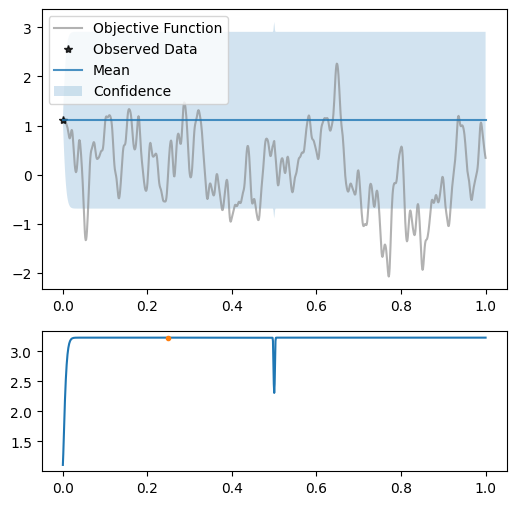

best oberved value: 1.1079166555859041
new point: [[0.24868311]]
new value: -0.017949245432629442
new acq: 3.2270384399240974
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.1
best_f: 1.1079166555859041

Iteration: 1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5450]), std = tensor([0.7961])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


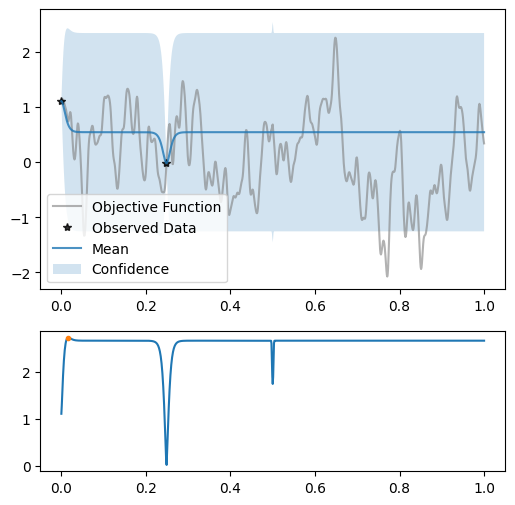

best oberved value: 1.1079166555859041
new point: [[0.01660817]]
new value: 0.7410725822753927
new acq: 2.728759551210927
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.2
best_f: 1.1079166555859041

Iteration: 2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6103]), std = tensor([0.5742])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


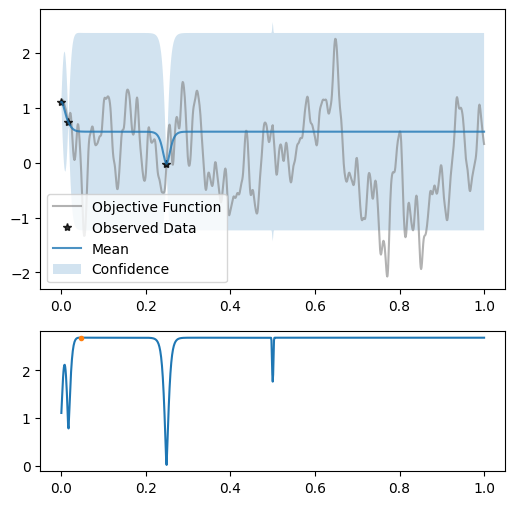

best oberved value: 1.1079166555859041
new point: [[0.04537627]]
new value: 0.0962079561468401
new acq: 2.686620556223252
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.30000000000000004
best_f: 1.1079166555859041

Iteration: 3
best oberved value: 1.1079166555859041
new point: [[0.50995464]]
new value: -0.21349306632064408
new acq: 2.556685812088034
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.4
best_f: 1.1079166555859041

Iteration: 4
best oberved value: 1.1079166555859041
new point: [[0.93334243]]
new value: 1.0302497549280345
new acq: 2.414328458973526
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.5
best_f: 1.1079166555859041

Iteration: 5


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4818]), std = tensor([0.5347])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3428]), std = tensor([0.5578])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4573]), std = tensor([0.5724])). Please consider scaling the 

best oberved value: 1.1079166555859041
new point: [[0.94947958]]
new value: 0.849786740235038
new acq: 2.6203097683550016
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.6
best_f: 1.1079166555859041

Iteration: 6


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5134]), std = tensor([0.5432])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1079166555859041
new point: [[0.91610545]]
new value: -0.7917640424974406
new acq: 2.6364320700351707
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.7
best_f: 1.1079166555859041

Iteration: 7
best oberved value: 1.1079166555859041
new point: [[0.96812918]]
new value: -0.484304648607346
new acq: 2.446612357839067
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.7999999999999999
best_f: 1.1079166555859041

Iteration: 8


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3503]), std = tensor([0.6825])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2575]), std = tensor([0.6964])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1079166555859041
new point: [[0.70911211]]
new value: -0.9766433454124018
new acq: 2.314911670723811
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.8999999999999999
best_f: 1.1079166555859041

Iteration: 9
best oberved value: 1.1079166555859041
new point: [[0.94102361]]
new value: 0.9897361344654965
new acq: 2.1878376147281395
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 0.9999999999999999
best_f: 1.1079166555859041

Iteration: 10


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1341]), std = tensor([0.7638])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2119]), std = tensor([0.7692])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1079166555859041
new point: [[0.0816803]]
new value: 0.3183695346562927
new acq: 2.1777695754938744
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.0999999999999999
best_f: 1.1079166555859041

Iteration: 11


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2208]), std = tensor([0.7340])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1079166555859041
new point: [[0.1040884]]
new value: 1.1774655645778191
new acq: 2.2155989898257777
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.2
best_f: 1.1774655645778191

Iteration: 12


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2944]), std = tensor([0.7512])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.1167744]]
new value: 0.9248011511457057
new acq: 2.4945685304850356
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.3
best_f: 1.1774655645778191

Iteration: 13


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3394]), std = tensor([0.7411])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.13409147]]
new value: -0.44057498583738236
new acq: 2.3743647468603832
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.4000000000000001
best_f: 1.1774655645778191

Iteration: 14
best oberved value: 1.1774655645778191
new point: [[0.37770357]]
new value: -0.7246992620124043
new acq: 2.2670819343124364
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.5000000000000002
best_f: 1.1774655645778191

Iteration: 15


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2874]), std = tensor([0.7420])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2241]), std = tensor([0.7602])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.0946127]]
new value: 0.5260879675281394
new acq: 2.215807201664872
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.6000000000000003
best_f: 1.1774655645778191

Iteration: 16


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2419]), std = tensor([0.7397])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.81234207]]
new value: -1.2785097708398325
new acq: 2.1937526862344967
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.7000000000000004
best_f: 1.1774655645778191

Iteration: 17


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1574]), std = tensor([0.8021])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.00758763]]
new value: 1.0476996644958738
new acq: 2.13286227757023
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.8000000000000005
best_f: 1.1774655645778191

Iteration: 18


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2043]), std = tensor([0.8058])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.29211937]]
new value: 1.1748811558582346
new acq: 2.0950581875564014
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 1.9000000000000006
best_f: 1.1774655645778191

Iteration: 19


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2528]), std = tensor([0.8138])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.3039751]]
new value: -0.020830585917451513
new acq: 2.4230018062892977
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.0000000000000004
best_f: 1.1774655645778191

Iteration: 20


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2398]), std = tensor([0.7955])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.28072082]]
new value: 0.7410477861143071
new acq: 2.456984474143786
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.1000000000000005
best_f: 1.1774655645778191

Iteration: 21


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2626]), std = tensor([0.7836])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.60622818]]
new value: 0.41406963065323366
new acq: 2.1571343891149803
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.2000000000000006
best_f: 1.1774655645778191

Iteration: 22


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2692]), std = tensor([0.7662])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.58650643]]
new value: 0.9259284189319266
new acq: 2.2054395095662436
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.3000000000000007
best_f: 1.1774655645778191

Iteration: 23


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2965]), std = tensor([0.7613])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.57232086]]
new value: 0.6107096588010531
new acq: 2.349971255253833
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.400000000000001
best_f: 1.1774655645778191

Iteration: 24


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3091]), std = tensor([0.7479])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.55246441]]
new value: 0.04026328798435109
new acq: 2.2539701668879717
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.500000000000001
best_f: 1.1774655645778191

Iteration: 25


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2988]), std = tensor([0.7347])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.62879092]]
new value: 1.044643472180938
new acq: 2.2366731373222324
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.600000000000001
best_f: 1.1774655645778191

Iteration: 26


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3264]), std = tensor([0.7346])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.1774655645778191
new point: [[0.64227538]]
new value: 1.5550299368911382
new acq: 2.426782784998567
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.700000000000001
best_f: 1.5550299368911382

Iteration: 27


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3703]), std = tensor([0.7573])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.5550299368911382
new point: [[0.65332326]]
new value: 1.8393690803420972
new acq: 2.616423008009951
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.800000000000001
best_f: 1.8393690803420972

Iteration: 28


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4209]), std = tensor([0.7921])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 1.8393690803420972
new point: [[0.6484326]]
new value: 2.262098867369933
new acq: 2.4413783825681357
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 2.9000000000000012
best_f: 2.262098867369933

Iteration: 29


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4823]), std = tensor([0.8478])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.66926178]]
new value: -0.13234331374038943
new acq: 2.3986207582253636
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.0000000000000013
best_f: 2.262098867369933

Iteration: 30


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4625]), std = tensor([0.8409])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.44581287]]
new value: -0.4267189281539041
new acq: 2.3227571301930476
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.1000000000000014
best_f: 2.262098867369933

Iteration: 31


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4347]), std = tensor([0.8420])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.64983637]]
new value: 2.220274041056969
new acq: 2.312904983045046
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.2000000000000015
best_f: 2.262098867369933

Iteration: 32


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4888]), std = tensor([0.8851])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.19485541]]
new value: -0.2988003232701949
new acq: 2.2945554549891023
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.3000000000000016
best_f: 2.262098867369933

Iteration: 33


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4656]), std = tensor([0.8820])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.86485285]]
new value: -1.1573841571952022
new acq: 2.2729059053382024
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.4000000000000017
best_f: 2.262098867369933

Iteration: 34


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4192]), std = tensor([0.9112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.76006038]]
new value: -1.4701266473334844
new acq: 2.2187243686165043
lmbda: tensor(0.0281)

new cost: 0.1
cumulative cost: 3.5000000000000018
best_f: 2.262098867369933

Iteration: 35


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3668]), std = tensor([0.9517])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


new_point_EIpu: tensor(0.0359)
best oberved value: 2.262098867369933
new point: [[0.33960447]]
new value: -0.369720431097958
new acq: 3.318242726250234
lmbda: tensor(0.0003)

new cost: 0.1
cumulative cost: 3.600000000000002
best_f: 2.262098867369933

Iteration: 36


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3469]), std = tensor([0.9462])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[1.]]
new value: 0.34142769027985315
new acq: 3.300496972712815
lmbda: tensor(0.0003)

new cost: 0.1
cumulative cost: 3.700000000000002
best_f: 2.262098867369933

Iteration: 37


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3467]), std = tensor([0.9333])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.47920436]]
new value: 0.6774690184314642
new acq: 3.310978068854289
lmbda: tensor(0.0003)

new cost: 0.1
cumulative cost: 3.800000000000002
best_f: 2.262098867369933

Iteration: 38


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3552]), std = tensor([0.9225])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.41292557]]
new value: -0.626910004965249
new acq: 3.330316028100132
lmbda: tensor(0.0003)

new cost: 0.1
cumulative cost: 3.900000000000002
best_f: 2.262098867369933

Iteration: 39


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3306]), std = tensor([0.9237])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 2.262098867369933
new point: [[0.22344646]]
new value: 0.2895785714747521
new acq: 3.301611660290063
lmbda: tensor(0.0003)

new cost: 0.1
cumulative cost: 4.000000000000002
best_f: 2.262098867369933



In [14]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIdecay_best = [best_f] # This will store the best value
cumulative_cost = 0
GIdecay_cumulative_cost_history = [0]

i = 0

while True:
    
    print("Iteration:", i)
    
    # Fit the model
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    if i == 0 or new_point_GIdecay.item() < best_f:
        
        # Optimize EIpu
        EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
        new_point, new_point_EIpu = optimize_acqf(
            acq_function=EIpu,
            bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
            q=1,
            num_restarts=20,
            raw_samples=1024,
            options={'method': 'L-BFGS-B'},
        )
        print("new_point_EIpu:", new_point_EIpu)
        
    # Optimize Gittins
    GIdecay = GittinsIndex(model=model, lmbda=new_point_EIpu/128, maximize=maximize, cost=cost_function)
    new_point, new_point_GIdecay = optimize_acqf(
        acq_function=GIdecay,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    if i < 3:
        
        # Plot the posterior and the Gittins
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
        # Plot the posterior
        plot_posterior(ax1, objective_function, model, test_x, x, y)
    
        # Plot Gittins
        GIdecay_acq = GIdecay.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), GIdecay_acq.detach().numpy(), '-', new_point.item(), new_point_GIdecay.item(), '.')
        plt.show()

    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIdecay.item())
    print("lmbda:", new_point_EIpu/128)
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIdecay_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    print("best_f:", best_f)
    print()
    GIdecay_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### TODO
- Play around with different decaying lambda

## Test Gittins policy with a small constant lambda

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1079]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


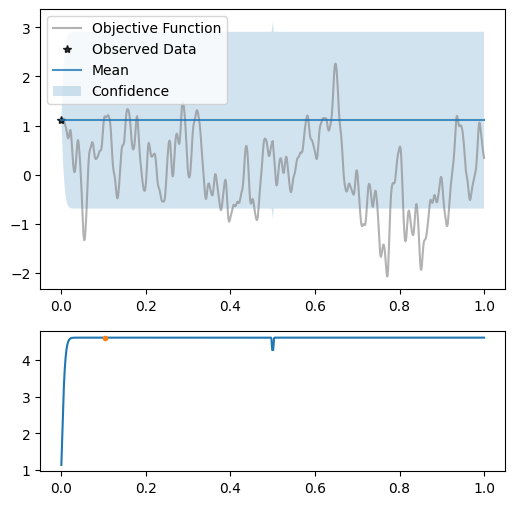

Iteration: 0
best oberved value: 1.1079166555859041
new point: [[0.10427476]]
new value: 1.1753983174254166
new acq: 4.617330223038483

new cost: 0.1
cumulative cost: 0.1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.1417]), std = tensor([0.0477])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


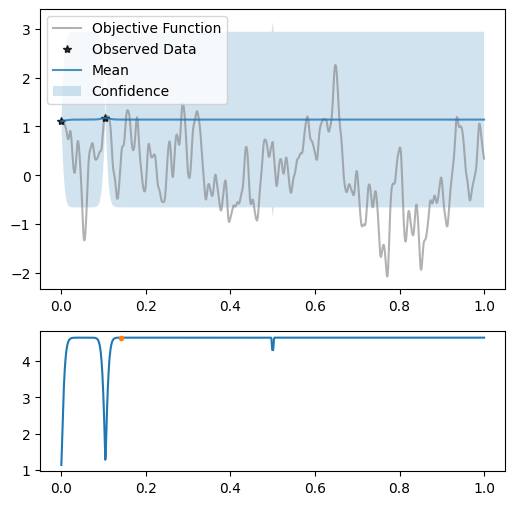

Iteration: 1
best oberved value: 1.1753983174254166
new point: [[0.14069311]]
new value: 0.315812029894513
new acq: 4.6512241815959285

new cost: 0.1
cumulative cost: 0.2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8664]), std = tensor([0.4780])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


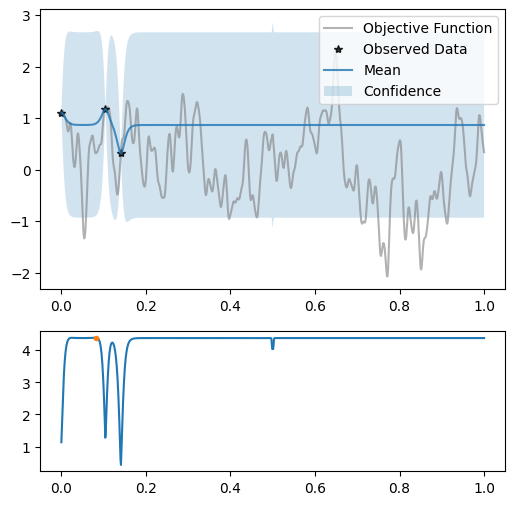

Iteration: 2
best oberved value: 1.1753983174254166
new point: [[0.08100687]]
new value: 0.31931871879818297
new acq: 4.389635409913343

new cost: 0.1
cumulative cost: 0.30000000000000004
Iteration: 3
best oberved value: 1.1753983174254166
new point: [[0.02203263]]
new value: 0.8897244134933335
new acq: 4.257331116415447

new cost: 0.1
cumulative cost: 0.4


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7296]), std = tensor([0.4766])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7616]), std = tensor([0.4189])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5842]), std = tensor([0.5739])). Please consider scaling the 

Iteration: 4
best oberved value: 1.1753983174254166
new point: [[0.70317931]]
new value: -0.3031447386725962
new acq: 4.262048320367741

new cost: 0.1
cumulative cost: 0.5
Iteration: 5
best oberved value: 1.1753983174254166
new point: [[0.9064652]]
new value: -0.7413380760248528
new acq: 4.074982686874291

new cost: 0.1
cumulative cost: 0.6
Iteration: 6
best oberved value: 1.1753983174254166
new point: [[0.11955863]]
new value: 0.5235830453640841
new acq: 3.9267962470231614

new cost: 0.1
cumulative cost: 0.7
Iteration: 7
best oberved value: 1.1753983174254166
new point: [[0.04255489]]
new value: 0.4711677368991352
new acq: 3.901355571024574

new cost: 0.1
cumulative cost: 0.7999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4109]), std = tensor([0.6726])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4176]), std = tensor([0.6295])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
best oberved value: 1.1753983174254166
new point: [[0.31042461]]
new value: 0.8116813366053778
new acq: 3.877888104834291

new cost: 0.1
cumulative cost: 0.8999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4570]), std = tensor([0.6065])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
best oberved value: 1.1753983174254166
new point: [[0.33223334]]
new value: 0.4697455095366532
new acq: 3.948666749452471

new cost: 0.1
cumulative cost: 0.9999999999999999
Iteration: 10
best oberved value: 1.1753983174254166
new point: [[0.28855137]]
new value: 1.4476021267424166
new acq: 3.949276728243966

new cost: 0.1
cumulative cost: 1.0999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4582]), std = tensor([0.5754])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5406]), std = tensor([0.6185])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
best oberved value: 1.4476021267424166
new point: [[0.27237854]]
new value: 0.8282690636544012
new acq: 4.127816365561333

new cost: 0.1
cumulative cost: 1.2
Iteration: 12
best oberved value: 1.4476021267424166
new point: [[0.5239508]]
new value: 0.08580338462065941
new acq: 4.022175529333229

new cost: 0.1
cumulative cost: 1.3


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5627]), std = tensor([0.5975])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5287]), std = tensor([0.5880])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
best oberved value: 1.4476021267424166
new point: [[0.24579245]]
new value: -0.4046970922187661
new acq: 3.991297827570338

new cost: 0.1
cumulative cost: 1.4000000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4665]), std = tensor([0.6158])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
best oberved value: 1.4476021267424166
new point: [[0.36957123]]
new value: -0.27921148658688755
new acq: 3.9215163799434123

new cost: 0.1
cumulative cost: 1.5000000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4199]), std = tensor([0.6234])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
best oberved value: 1.4476021267424166
new point: [[0.803633]]
new value: 0.4167781314222523
new acq: 3.8724788282160443

new cost: 0.1
cumulative cost: 1.6000000000000003


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4197]), std = tensor([0.6036])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
best oberved value: 1.4476021267424166
new point: [[0.7695946]]
new value: -2.019632233262588
new acq: 3.876368485655938

new cost: 0.1
cumulative cost: 1.7000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2842]), std = tensor([0.8207])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
best oberved value: 1.4476021267424166
new point: [[0.82900708]]
new value: -1.1405328699462547
new acq: 3.735672475720442

new cost: 0.1
cumulative cost: 1.8000000000000005


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2092]), std = tensor([0.8619])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
best oberved value: 1.4476021267424166
new point: [[0.1682251]]
new value: 0.5527294116600727
new acq: 3.655465008554792

new cost: 0.1
cumulative cost: 1.9000000000000006


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2263]), std = tensor([0.8424])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
best oberved value: 1.4476021267424166
new point: [[0.1901571]]
new value: 0.004996850490187607
new acq: 3.693603495455349

new cost: 0.1
cumulative cost: 2.0000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2158]), std = tensor([0.8225])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
best oberved value: 1.4476021267424166
new point: [[0.60901989]]
new value: 0.732330200148795
new acq: 3.664274292962803

new cost: 0.1
cumulative cost: 2.1000000000000005


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2393]), std = tensor([0.8102])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
best oberved value: 1.4476021267424166
new point: [[0.62867658]]
new value: 1.051207135003398
new acq: 3.7338743220618227

new cost: 0.1
cumulative cost: 2.2000000000000006


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2746]), std = tensor([0.8095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
best oberved value: 1.4476021267424166
new point: [[0.64592506]]
new value: 2.134153741501159
new acq: 3.809569210260867

new cost: 0.1
cumulative cost: 2.3000000000000007


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3521]), std = tensor([0.8780])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
best oberved value: 2.134153741501159
new point: [[0.65754361]]
new value: 1.16443362221017
new acq: 4.203482266298877

new cost: 0.1
cumulative cost: 2.400000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3846]), std = tensor([0.8747])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
best oberved value: 2.134153741501159
new point: [[0.58712901]]
new value: 0.8710719960212507
new acq: 3.821346760043383

new cost: 0.1
cumulative cost: 2.500000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4033]), std = tensor([0.8624])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
best oberved value: 2.134153741501159
new point: [[0.45127266]]
new value: -0.5115518461868478
new acq: 3.8232520572133577

new cost: 0.1
cumulative cost: 2.600000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3694]), std = tensor([0.8637])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
best oberved value: 2.134153741501159
new point: [[0.56770489]]
new value: 0.4480729902756585
new acq: 3.829916742163589

new cost: 0.1
cumulative cost: 2.700000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3722]), std = tensor([0.8477])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
best oberved value: 2.134153741501159
new point: [[0.99939522]]
new value: 0.36964526285025767
new acq: 3.7909878191047754

new cost: 0.1
cumulative cost: 2.800000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3721]), std = tensor([0.8324])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
best oberved value: 2.134153741501159
new point: [[0.96848111]]
new value: -0.46714674603448325
new acq: 3.795379280908601

new cost: 0.1
cumulative cost: 2.9000000000000012


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3441]), std = tensor([0.8322])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
best oberved value: 2.134153741501159
new point: [[0.40945736]]
new value: -0.6249940115229636
new acq: 3.76090261324602

new cost: 0.1
cumulative cost: 3.0000000000000013


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3129]), std = tensor([0.8365])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
best oberved value: 2.134153741501159
new point: [[0.4913919]]
new value: 0.37482701028107795
new acq: 3.727526382078632

new cost: 0.10000000000000016
cumulative cost: 3.1000000000000014


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3148]), std = tensor([0.8230])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
best oberved value: 2.134153741501159
new point: [[0.67618837]]
new value: -0.3278653592673577
new acq: 3.7260988599940728

new cost: 0.1
cumulative cost: 3.2000000000000015


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2953]), std = tensor([0.8177])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
best oberved value: 2.134153741501159
new point: [[0.86873387]]
new value: -0.8330041870999411
new acq: 3.7078506452957454

new cost: 0.1
cumulative cost: 3.3000000000000016


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2622]), std = tensor([0.8282])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
best oberved value: 2.134153741501159
new point: [[0.6385268]]
new value: 1.1114477782931569
new acq: 3.692856308275223

new cost: 0.1
cumulative cost: 3.4000000000000017


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2864]), std = tensor([0.8284])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
best oberved value: 2.134153741501159
new point: [[0.54717381]]
new value: -0.15805096931742332
new acq: 3.6564426948649427

new cost: 0.1
cumulative cost: 3.5000000000000018


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2741]), std = tensor([0.8199])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
best oberved value: 2.134153741501159
new point: [[0.73227283]]
new value: -0.3723143267761576
new acq: 3.6395616507331976

new cost: 0.1
cumulative cost: 3.600000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2566]), std = tensor([0.8153])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
best oberved value: 2.134153741501159
new point: [[0.29861458]]
new value: 0.16258772648835884
new acq: 3.62788475325417

new cost: 0.1
cumulative cost: 3.700000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2541]), std = tensor([0.8044])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
best oberved value: 2.134153741501159
new point: [[0.06123336]]
new value: -0.3478205994445546
new acq: 3.6172068592408593

new cost: 0.1
cumulative cost: 3.800000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2387]), std = tensor([0.7996])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
best oberved value: 2.134153741501159
new point: [[0.21606389]]
new value: 0.3818959005524488
new acq: 3.603004612143039

new cost: 0.1
cumulative cost: 3.900000000000002
Iteration: 39
best oberved value: 2.134153741501159
new point: [[0.93836045]]
new value: 1.0993376980719667
new acq: 3.6066714700955345

new cost: 0.1
cumulative cost: 4.000000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2423]), std = tensor([0.7896])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [15]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex
x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    if i < 3:

        # Plot the posterior and the Gittins
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
        # Plot the posterior
        plot_posterior(ax1, objective_function, model, test_x, x, y)
    
        # Plot Gittins
        GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
        plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIlmbda.item())
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget=1+delta

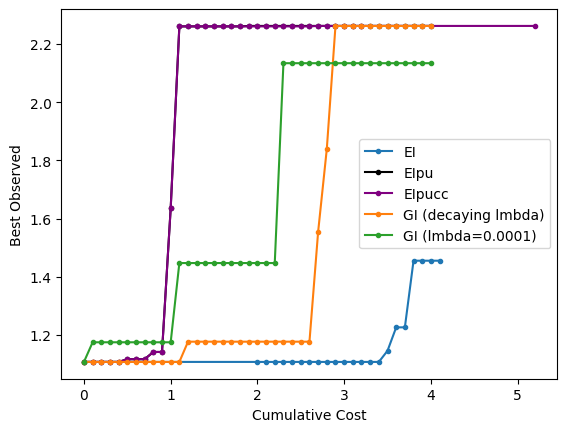

In [16]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(EIpu_cumulative_cost_history, EIpu_best, '.-', label="EIpu", color='black')
plt.plot(EIpucc_cumulative_cost_history, EIpucc_best, '.-', label="EIpucc", color='purple')
plt.plot(GIdecay_cumulative_cost_history, GIdecay_best, '.-', label="GI (decaying lmbda)")
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()

### Question
- Shall we caculate the average regret rather than the average best observed value across different instances?

- Shall we set a larger budget?

### TODO
- A sweep with different smoothness, lengthscales and seeds